# Aprendizaje por transferencia

In [2]:
import numpy as np
import torch as th
import math
import os
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import PIL
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
from torch.optim import Adam

Constantes generales del programa.

In [3]:
SEMILLA = 150
th.manual_seed(SEMILLA)
np.random.seed(SEMILLA)
T_LOTE = 64
T_IMAGEN_RESIZED = (64, 64) # posible cambio
N_EPOCAS = 10
LOGDIR = './logs/'
DC = 'cuda:0' if th.cuda.is_available() else 'cpu'

Se clona el conjunto de datos de github.

In [4]:
!git clone https://github.com/epeto/fairface.git

Cloning into 'fairface'...
remote: Enumerating objects: 97549, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 97549 (delta 1), reused 7 (delta 1), pack-reused 97542
Receiving objects: 100% (97549/97549), 536.87 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (97701/97701), done.


Se construyen diccionarios que relacionen una categoría en string con una categoría en entero.

In [5]:
def extract_num(cadena):
    salida = cadena[-1]
    if cadena[-2].isdigit():
        salida = cadena[-2] + salida
    return int(salida)

# Construye dos diccionarios para una lista de categorías
def build_dict(cats):
    cats = list(np.unique(cats))
    cats.sort(key=extract_num)
    str_a_ind = {} # cadena a índice
    ind_a_str = {} # índice a cadena
    for i,s in enumerate(cats):
        str_a_ind[s] = i
        ind_a_str[i] = s
    return str_a_ind, ind_a_str

datos_csv = pd.read_csv('fairface/fairface_label_train.csv')
str_a_ind, ind_a_str = build_dict(datos_csv['age'].to_numpy())
n_clases = len(str_a_ind)
print(str_a_ind)
print(ind_a_str)
print('Número de clases:', n_clases)

{'0-2': 0, '3-9': 1, '10-19': 2, '20-29': 3, '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, 'more than 70': 8}
{0: '0-2', 1: '3-9', 2: '10-19', 3: '20-29', 4: '30-39', 5: '40-49', 6: '50-59', 7: '60-69', 8: 'more than 70'}
Número de clases: 9


In [6]:
# construye el dataset a partir del csv
def build_dataset(dataset_csv, diccionario):
    X = dataset_csv['file']
    edades = dataset_csv['age']
    y = [diccionario[rango] for rango in edades]
    X = np.array(list(map(lambda s : 'fairface/'+s, X)))
    y = np.array(y)
    return X, y

Observamos los primeros 10 datos del conjunto de entrenamiento.

In [7]:
X_ent, y_ent = build_dataset(datos_csv, str_a_ind)
print(X_ent[:10])
print(y_ent[:10])

['fairface/train/1.jpg' 'fairface/train/2.jpg' 'fairface/train/3.jpg'
 'fairface/train/4.jpg' 'fairface/train/5.jpg' 'fairface/train/6.jpg'
 'fairface/train/7.jpg' 'fairface/train/8.jpg' 'fairface/train/9.jpg'
 'fairface/train/10.jpg']
[6 4 1 3 3 3 5 4 2 4]


Se subdivide el conjunto de entrenamiento en entrenamiento y validación.

In [8]:
# la estratificación se realiza por default con el conjunto de etiquetas (y_ent)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent, y_ent, test_size=0.2, random_state=SEMILLA, shuffle=True)

Se aplica el mismo preprocesamiento al conjunto de prueba.

In [9]:
X_pru, y_pru = build_dataset(pd.read_csv('fairface/fairface_label_val.csv'), str_a_ind)

## Carga de datos

In [10]:
class Fairface(Dataset):
    def __init__(self, imagenes, categorias, transform=None):
        self.imagenes = imagenes
        self.categorias = categorias
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imagenes[idx])
        cat = self.categorias[idx]

        if self.transform:
            img = self.transform(img)

        return img, cat

    def __len__(self):
        return len(self.imagenes)

ds_ent = Fairface(X_ent, y_ent)

Observamos una imagen

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7FEF6D637D30>
Categoría = 4
Etiqueta = 30-39


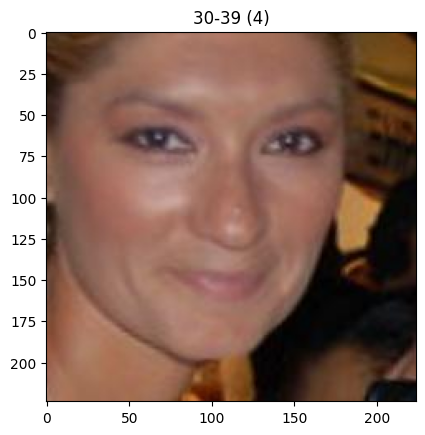

In [11]:
it_ent = iter(ds_ent)
par_ent = next(it_ent)
print('Imagen =',par_ent[0])
print('Categoría =', par_ent[1])
print('Etiqueta =', ind_a_str[par_ent[1]])

plt.imshow(par_ent[0])
cat_ej = par_ent[1]
plt.title(f'{ind_a_str[cat_ej]} ({cat_ej})')
plt.show()

Se crean las mismas clases para los conjuntos de validación y prueba.

In [12]:
ds_val = Fairface(X_val, y_val)
ds_pru = Fairface(X_pru, y_pru)

## Acrecentamiento de datos

Se definen las funciones de transformación para los conjuntos de entrenamiento, validación y prueba.

* Para entrenamiento se usará una composición de: `RandomCrop`, `Pad`, `RandomPerspective` y `Resize`.
* Para validación y prueba sólo se hará un `Resize`.

Al final se aplica `T.ToImage()` seguido de `T.ToDtype(torch.float32, scale=True)`, para cambiar de imagen de Pillow a un tensor de PyTorch.

PD: se cambió a `T.ToTensor()`

In [13]:
CROP_SIZE = (170, 170)
# v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
transform_ent = T.Compose([T.RandomCrop(CROP_SIZE),
                           T.Pad(padding=20),
                           T.RandomPerspective(distortion_scale=0.3),
                           T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToTensor()])

transform_val = T.Compose([T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToTensor()])

transform_pru = T.Compose([T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToTensor()])

# Se agrega cada función a su respectivo atributo de objeto
ds_ent.transform = transform_ent
ds_val.transform = transform_val
ds_pru.transform = transform_pru

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Carga de datos por lotes

Se crea el cargador de datos para el conjunto de entrenamiento.

In [14]:
# muestra un lote de imágenes
def muestra_imagenes(imgs, etiq):
    t_muestra = imgs.shape[0]
    n_filas = n_cols = int(math.sqrt(t_muestra))
    fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(2*n_filas, 2*n_cols))

    for i in range(n_filas):
        for j in range(n_cols):
            idx = i*n_filas + j
            ax[i,j].imshow(imgs[idx])
            ax[i,j].axis('off')
            ax[i,j].set_title(etiq[idx])
    plt.tight_layout()
    plt.show()

In [15]:
dataloader_ent = DataLoader(ds_ent, batch_size=T_LOTE, shuffle=True)
it_entdl = iter(dataloader_ent)
lote_ejemplo = next(it_entdl)
print('Imágenes =', lote_ejemplo[0].shape)
print('Categorías =', lote_ejemplo[1].shape)

Imágenes = torch.Size([64, 3, 64, 64])
Categorías = torch.Size([64])


Se visualiza un subconjunto de 9 imágenes del lote.

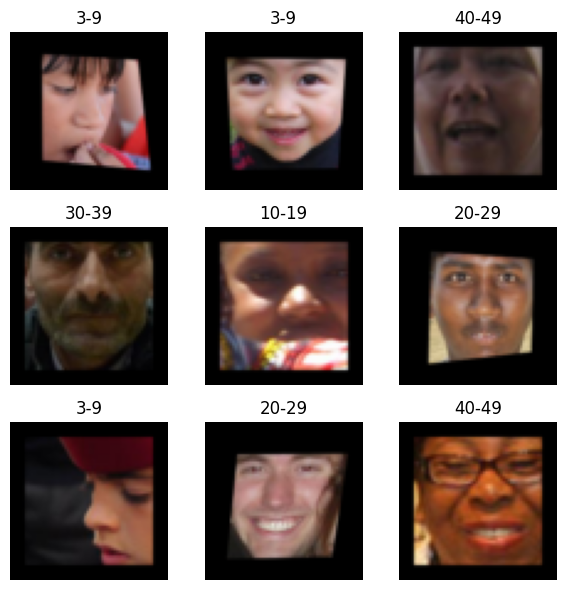

In [16]:
imgs = lote_ejemplo[0][:9]
etiqs = [ind_a_str[c] for c in lote_ejemplo[1][:9].numpy()]
muestra_imagenes(imgs.permute(0,2,3,1).numpy(), etiqs)

Se crean los cargadores para los conjuntos de validación y prueba.

In [17]:
dataloader_val = DataLoader(ds_val, batch_size=T_LOTE, shuffle=True)
dataloader_pru = DataLoader(ds_pru, batch_size=1, shuffle=True)

## Funciones para el entrenamiento

In [18]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
    estado_modelo = {'epoch': epoca,
                     'model_state_dict': modelo.state_dict(),
                     'optimizer_state_dict': opt.state_dict()}
    th.save(estado_modelo, ckptpath)

In [19]:
from torch.utils.tensorboard import SummaryWriter

def registra_info_tboard(writer, epoca, hist):
    for (m,v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [20]:
def exactitud(y_hat, y):
    cmp = y_hat.argmax(dim=-1) == y
    aciertos = th.count_nonzero(cmp)
    return aciertos / cmp.shape[0]

In [21]:
def paso_ent(modelo, fp, metrica, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros a actualizar en cero
    y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
    perdida = fp(y_hat, y) # se calcula la pérdida
    perdida.backward() # se obtienen los gradientes
    opt.step() # se actualizan todos los parámetros del modelo

    with th.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de Tensor de orden 0) a NumPy, para lo que es necesario moverla a CPU
        metricas_paso = metrica(y_hat, y)

    return perdida_paso, metricas_paso

## Transferencia parte 1 - Actualización de última capa

Se elegirá la red googlenet para clasificación de imágenes.

In [23]:
import torchvision as tv

Se instancían los pesos de la red con una red preentrenada.

In [26]:
googlenet = tv.models.googlenet(weights = tv.models.GoogLeNet_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 92.9MB/s]


Congelación de la red.

In [27]:
for p in googlenet.parameters():
    p.requires_grad = False

Se cambia la capa de salida.

In [43]:
entrada_uc = googlenet.fc.in_features
googlenet.fc = nn.Linear(entrada_uc, n_clases)

NameError: ignored

Definición de la función de entrenamiento por transferencia.

In [24]:
import copy

def entrena_transferencia(modelo, fp, metrica, opt, entdl, valdl, disp, ckptpath, n_epocas = 10, tbdir = 'runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'ent': {'perdida': np.zeros(n_epocas), metrica.__name__: np.zeros(n_epocas)},
            'val': {'perdida': np.zeros(n_epocas), metrica.__name__: np.zeros(n_epocas)}}
    tbwriter_ent = SummaryWriter(tbdir + '/ent')
    tbwriter_val = SummaryWriter(tbdir + '/val')
    perdida_min = th.inf
    mejor_modelo = copy.deepcopy(modelo)

    for e in range(n_epocas):
        # bucle de entrenamiento
        for p, (Xlote,ylote) in enumerate(entdl):
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)
            hist["ent"]['perdida'][e] += perdida_paso
            hist["ent"][metrica.__name__][e] += metrica_paso
        # bucle de validación
        with th.no_grad():
            for Xlote,ylote in valdl:
                Xlote = Xlote.to(disp)
                ylote = ylote.to(disp)
                y_hat = modelo(Xlote)
                hist['val']['perdida'][e] += fp(y_hat, ylote)
                hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

        hist['ent']['perdida'][e] /=  n_lotes_ent
        hist['ent'][metrica.__name__][e] /= n_lotes_ent
        hist['val']['perdida'][e] /=  n_lotes_val
        hist['val'][metrica.__name__][e] /= n_lotes_val

        # guardamos checkpoint y copiamos pesos y sesgos del modelo
        # actual si disminuye la metrica a monitorear
        if hist['val']['perdida'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)

        registra_info_tboard(tbwriter_ent, e, hist['ent'])
        registra_info_tboard(tbwriter_val, e, hist['val'])

        print(f'\nÉpoca {e}: Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, {metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, Perdida(V) = {hist["val"]["perdida"][e]:.3f}, {metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

    return modelo, mejor_modelo, hist

Instanciamos el criterio para la pérdida, el optimizador, movemos la red a la GPU, la ponemos en modo evaluación y llamamos a la función `entrena_transferencia`.

In [34]:
googlenet.to(DC)
perdida = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.01)
opt = Adam(googlenet.parameters(), lr=0.001)

googlenet.eval()
googlenet, mejor_resnet50, hist = entrena_transferencia(googlenet, perdida, exactitud, opt, dataloader_ent, dataloader_val, DC, LOGDIR + '/googlenet_tl.pt', n_epocas=N_EPOCAS, tbdir = LOGDIR)


Época 0: Perdida(E) = 1.813, exactitud(E) = 0.299, Perdida(V) = 2.300, exactitud(V) = 0.251

Época 1: Perdida(E) = 1.782, exactitud(E) = 0.308, Perdida(V) = 2.632, exactitud(V) = 0.211

Época 2: Perdida(E) = 1.776, exactitud(E) = 0.312, Perdida(V) = 2.534, exactitud(V) = 0.227

Época 3: Perdida(E) = 1.769, exactitud(E) = 0.314, Perdida(V) = 2.625, exactitud(V) = 0.222

Época 4: Perdida(E) = 1.765, exactitud(E) = 0.313, Perdida(V) = 2.533, exactitud(V) = 0.210

Época 5: Perdida(E) = 1.763, exactitud(E) = 0.316, Perdida(V) = 2.891, exactitud(V) = 0.229

Época 6: Perdida(E) = 1.760, exactitud(E) = 0.313, Perdida(V) = 3.151, exactitud(V) = 0.189

Época 7: Perdida(E) = 1.760, exactitud(E) = 0.312, Perdida(V) = 2.529, exactitud(V) = 0.265

Época 8: Perdida(E) = 1.761, exactitud(E) = 0.313, Perdida(V) = 2.380, exactitud(V) = 0.256

Época 9: Perdida(E) = 1.759, exactitud(E) = 0.315, Perdida(V) = 2.564, exactitud(V) = 0.223


In [35]:
mejor_googlenet = mejor_resnet50 # se me olvidó cambiar el nombre de la variable con anticipación

Se verifica la exactitud en el conjunto de prueba.

In [36]:
total_pru = 0
acum_exact = 0.
for X_pru, y_pru in dataloader_pru:
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_googlenet(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom*100, "%")

Exactitud en conjunto de prueba:
 tensor(22.5580, device='cuda:0') %


In [38]:
print("Exactitud en conjunto de prueba:\n", exact_prom)

Exactitud en conjunto de prueba:
 tensor(0.2256, device='cuda:0')


La exactitud es baja (22.56%) y coincide con la exactitud en el conjunto de validación (22.3%).

Se grafica la función de pérdida y la exactitud.

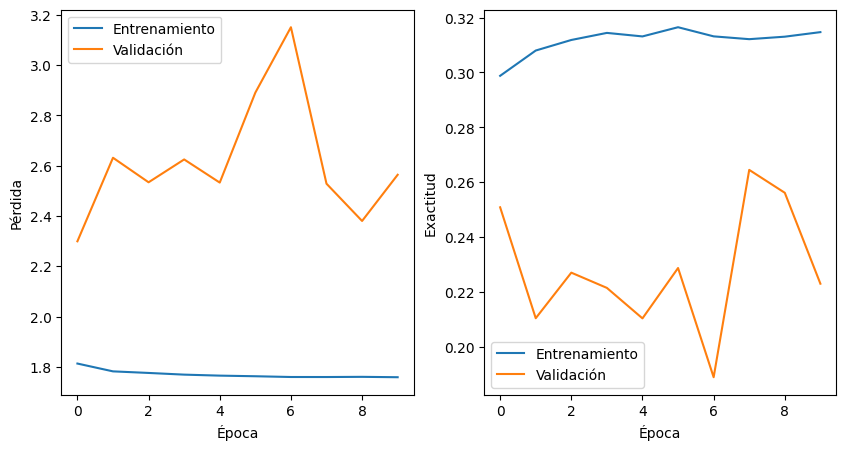

In [44]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

Puede observarse que la exactitud no mejora mucho en 10 épocas, en el conjunto de validación. Mejora solo un poco en el conjunto de entrenamiento.

## Transferencia parte 2 - actualización de la red completa

In [25]:
def entrena_ajuste_fino(modelo, fp, metrica, opt, entdl, valdl, disp, ckptpath, n_epocas = 10, tbdir = 'runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'ent': {'perdida': np.zeros(n_epocas), metrica.__name__: np.zeros(n_epocas)},
            'val': {'perdida': np.zeros(n_epocas), metrica.__name__: np.zeros(n_epocas)}
    }

    tbwriter_ent = SummaryWriter(tbdir + '/ent')
    tbwriter_val = SummaryWriter(tbdir + '/val')

    perdida_min = th.inf
    mejor_modelo = copy.deepcopy(modelo)

    for e in range(n_epocas):
        # bucle de entrenamiento
        modelo.train()
        for p, (Xlote,ylote) in enumerate(entdl):
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)
            hist["ent"]['perdida'][e] += perdida_paso
            hist["ent"][metrica.__name__][e] += metrica_paso

        # bucle de validación
        modelo.eval()
        with th.no_grad():
            for Xlote,ylote in valdl:
                Xlote = Xlote.to(disp)
                ylote = ylote.to(disp)
                y_hat = modelo(Xlote)
                hist['val']['perdida'][e] += fp(y_hat, ylote)
                hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

        hist['ent']['perdida'][e] /=  n_lotes_ent
        hist['ent'][metrica.__name__][e] /= n_lotes_ent
        hist['val']['perdida'][e] /=  n_lotes_val
        hist['val'][metrica.__name__][e] /= n_lotes_val

        # guardamos checkpoint y copiamos pesos y sesgos del modelo
        # actual si disminuye la metrica a monitorear
        if hist['val']['perdida'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)

        registra_info_tboard(tbwriter_ent, e, hist['ent'])
        registra_info_tboard(tbwriter_val, e, hist['val'])

        print(f'\nÉpoca {e}: '
              f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
              f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
              f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
              f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

    return modelo, mejor_modelo, hist

In [26]:
# liberación de memoria
del googlenet

Se elegirá una nueva red (*Resnet50*) para el modelo.

Fase de entrenamiento con ajuste fino.

In [32]:
resnet50 = tv.models.resnet50(weights = tv.models.ResNet50_Weights.IMAGENET1K_V1)
for p in resnet50.parameters():
    p.requires_grad = True
uc = resnet50.fc.in_features
resnet50.fc = nn.Linear(uc, n_clases)

resnet50.to(DC)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(resnet50.parameters(),
           lr=1e-4)

resnet50, mejor_resnet50, hist = entrena_ajuste_fino(resnet50,
                                                     perdida,
                                                     exactitud,
                                                     opt,
                                                     dataloader_ent,
                                                     dataloader_ent,
                                                     DC,
                                                     LOGDIR + '/resnet50_ft.pt',
                                                     n_epocas=N_EPOCAS,
                                                     tbdir = LOGDIR)

KeyboardInterrupt: ignored

Se vuelve a hacer la comparación con el conjunto de prueba y las gráficas.

In [ ]:
total_pru = 0
acum_exact = 0.
for X_pru, y_pru in dataloader_pru:
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_googlenet(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom)

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()